In [9]:
import pandas as pd
import numpy as np
from numpy import tanh

In [10]:
# The sample
x = np.array([0.2, 0.3, 0.4])
y = 7.0

# Initialize Weights
Wc = np.array([0.2, 0.4])

Wo = np.array([0.1, 3.1])
Wf = np.array([2.3, 0.2])
Wi = np.array([3.1, 0.1])

Uc = np.array([[1.8, 3.6], [4.7, 2.9]])
Uo = np.array([[0.1, 0.9], [0.7, 4.3]])
Uf = np.array([[3.6, 4.1], [1.0, 0.9]])
Ui = np.array([[1.5, 2.6], [2.1, 0.2]])

w = np.array([2.0, 4.0])

# Backpropagation LSTM
$
% Forget-Gate
\newcommand{\F}{\color{purple}{f_t}}
\newcommand{\Ffull}[1][]{\color{purple}{\sigma^{#1} \left( W_f + U_f \cdot h_{t-1} \right)}}
\newcommand{\f}[1]{\color{purple}{f^t_{#1}}}
\newcommand{\ffull}[2][]{\color{purple}{\sigma^{#1} \left(w^f_{#2} x_t + u^f_{#2 1} h^{t-1}_1 + u^f_{#2 2}h^{t-1}_2 \right)}}
\newcommand{\Wf}{\color{purple}{W_f}}
\newcommand{\Uf}{\color{purple}{U_f}}
\newcommand{\wf}[1]{\color{purple}{w_{#1}^f}}
\newcommand{\uf}[2]{\color{purple}{u_{#1 #2}^f}}
% Input-Gate
\newcommand{\I}{\color{fuchsia}{i_t}}
\newcommand{\Ifull}[1][]{\color{fuchsia}{\sigma^{#1} \left( W_i + U_i \cdot h_{t-1} \right)}}
\newcommand{\i}[1]{\color{fuchsia}{i^t_{#1}}}
\newcommand{\ifull}[2][]{\color{fuchsia}{\sigma^{#1} \left( w^i_{#2} x_t + u^i_{#2 1} h^{t-1}_1 + u^i_{#2 2} h^{t-1}_2 \right)}}
\newcommand{\Wi}{\color{fuchsia}{W_i}}
\newcommand{\Ui}{\color{fuchsia}{U_i}}
\newcommand{\wi}[1]{\color{fuchsia}{w_{#1}^i}}
\newcommand{\ui}[2]{\color{fuchsia}{u_{#1 #2}^i}}
% Output-Gate
\newcommand{\O}{\color{turquoise}{o_t}}
\newcommand{\Ofull}[1][]{\color{turquoise}{\sigma^{#1} \left( W_o + U_o \cdot h_{t-1} \right)}}
\newcommand{\o}[1]{\color{turquoise}{o^t_{#1}}}
\newcommand{\ofull}[2][]{\color{turquoise}{\sigma^{#1} \left( w^o_{#2} x_t + u^o_{#2 1} h^{t-1}_1 + u^o_{#2 2} h^{t-1}_2 \right)}}
\newcommand{\Wo}{\color{turquoise}{W_o}}
\newcommand{\Uo}{\color{turquoise}{U_o}}
\newcommand{\wo}[1]{\color{turquoise}{w_{#1}^o}}
\newcommand{\uo}[2]{\color{turquoise}{u_{#1 #2}^o}}
% Cell (c without tilde - or however the fuck it's supposed to be called)
\newcommand{\C}[1][]{\color{lime}{c_{t #1}}}
\newcommand{\Cfull}{\F * \C[-1] + \I * \Ctil}
\newcommand{\c}[2][]{\color{lime}{c^{t #1}_{#2}}}
% Candidate (c with tilde - again: whatever, it's fine.)
\newcommand{\Ctil}{\color{green}{\tilde{c}_t}}
\newcommand{\Ctilfull}[1][]{\color{green}{g^{#1} \left( W_c x_t + U_c \cdot h_{t-1} \right)}}
\newcommand{\ctil}[2][]{\color{green}{g^{#1} \left( w^c_{#2} x_t + u^c_{#2 1} h^{t-1}_1 + u^c_{#2 2} h^{t-1}_2 \right)}}
\newcommand{\ctils}[1]{\color{green}{\tilde{c}_{#1}}}
\newcommand{\Wc}{\color{green}{W_c}}
\newcommand{\Uc}{\color{green}{U_c}}
\newcommand{\wc}[1]{\color{green}{w_{#1}^c}}
\newcommand{\uc}[2]{\color{green}{u_{#1 #2}^c}}
% Miscellaneous
\newcommand{\yhat}{\hat{y}_t}
\newcommand{\error}{\left(y - \yhat \right)}
\newcommand{\deriv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\dxt}[1]{\color{#1}{x_t}}
\DeclareMathOperator{\diag}{diag}
\newcommand{\myH}[2][-1]{\color{#2}{h_{t #1}}}
\newcommand{\myh}[2][red]{\color{#1}{h^{t-1}_{#2}}}
$
In order to demonstrate how the backpropagation on the LSTM works we will further investigate our previous example. Remember, that we used a $3 \times 1$ vector for our single sample. Additionally, we looked at a very simple neural network that has only 2 neurons. Typically, we want to find better weights in each consecutive training iteration and in order to achieve that we follow a fraction of the negative gradient of a loss function.

So right now, we need two things:
1. a loss function
1. and its gradients with respect to each of the weight matrices.

Regarding the loss function we can make our lives easier by picking one, that is fit for our regression task while also being easy to derive. One of the easiest loss functions for that matter is the sum of squared errors, which we scale by a convenient constant:

$$loss_t = \frac{1}{2}\left( y - \yhat \right)^2.$$

Where $\yhat$ is the prediction at timestep $t$. When taking the derivative with respect to $\yhat$ one can easily see:

$$\deriv{loss_t}{\yhat} = \left( y - \yhat \right) (-1)$$

We define our total loss to be the sum of the losses at each timestep:

$$loss = \sum loss_t$$

This is also the reason, why the LSTM architecture remedies the vanishing or exploding gradients. Instead of resulting in a huge product as in the backpropagation through time, we will simply add the gradients of each timestep's contribution \[[Mallya 2017](http://arunmallya.github.io/writeups/nn/lstm/index.html)\].

Now that we know what function we want to derive we also need to know which weights we want to tune. We define the weight matrices as

\begin{alignat}{2}
% Weight matrices
\Wo &= \begin{bmatrix} \wo{1} \\ \wo{2} \end{bmatrix} \quad \Uo &&= \begin{bmatrix} \uo{1}{1} & \uo{1}{2} \\ \uo{2}{1} & \uo{2}{2} \end{bmatrix} \\
\Wf &= \begin{bmatrix} \wf{1} \\ \wf{2} \end{bmatrix} \quad \Uf &&= \begin{bmatrix} \uf{1}{1} & \uf{1}{2} \\ \uf{2}{1} & \uf{2}{2} \end{bmatrix} \\
\Wi &= \begin{bmatrix} \wi{1} \\ \wi{2} \end{bmatrix} \quad \Ui &&= \begin{bmatrix} \ui{1}{1} & \ui{1}{2} \\ \ui{2}{1} & \ui{2}{2} \end{bmatrix} \\
\Wc &= \begin{bmatrix} \wc{1} \\ \wc{2} \end{bmatrix} \quad \Uc &&= \begin{bmatrix} \uc{1}{1} & \uc{1}{2} \\ \uc{2}{1} & \uc{2}{2} \end{bmatrix}
\end{alignat}

Additionally, define the LSTM-forward pass as

\begin{align}
% Forward pass
\myH[]{red} &= \O * g(\C) \tag{1} \\
\C &= \F * \C[-1] + \I * \Ctil \tag{2} \\
\Ctil &= \Ctilfull = \begin{pmatrix} 
                         \ctil{1} \\ \ctil{2}
                     \end{pmatrix} \tag{3} \\
\I &= \begin{pmatrix} 
           \i{1} \\ \i{2} 
      \end{pmatrix} 
   = \Ifull
   = \begin{pmatrix}
         \ifull{1} \\ \ifull{2} 
     \end{pmatrix} \tag{4} \\
\F &= \begin{pmatrix} 
          \f{1} \\ \f{2} 
      \end{pmatrix} 
   = \Ffull 
   = \begin{pmatrix} 
         \ffull{1} \\ \ffull{2} 
     \end{pmatrix} \tag{5} \\
\O &= \begin{pmatrix} 
          \o{1} \\ \o{2} 
      \end{pmatrix} 
   = \Ofull
   = \begin{pmatrix} 
         \ofull{1} \\ \ofull{2}
     \end{pmatrix} \tag{6}
\end{align}

Where we choose the activation functions $\sigma$ as the sigmoid function and $g$ as the hyperbolic function \[[cp Dey, Salem 2017](https://arxiv.org/pdf/1701.05923.pdf)\].

\begin{alignat}{3}
\sigma(x) &= \frac{\exp(-x)}{1 + \exp(-x} &&\quad\text{with}\quad \deriv{\sigma(x)}{x} &&&= \sigma(x) (1-\sigma(x)) \\
g(x) &= \tanh(x) &&\quad\text{with}\quad \deriv{g(x)}{x} &&&= 1 - \tanh^2(x)
\end{alignat}

In [11]:
# Define activation functions
def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))


def dsigmoid(x):
    """Derivative of sigmoid function."""
    return sigmoid(x) * (1 - sigmoid(x))


def dtanh(x):
    """Derivative of tanh function."""
    return 1 - np.tanh(x)**2

Let's also, for our purposes define the forward pass again, this time with a small change. This time, we want to store the results of every operation that depends on the timestep $t$ in their own lists. And we want to define a function that we can call later in a more convenient fashion.

In [12]:
# Redefine forward pass
h = []
o = []
f = []
i = []
c_ = []
c = []
y_ = []

def LSTM_forward():
    """Perform forward pass"""
    
    # First, set hidden state to zero
    h.append(np.zeros_like(Wc))
    c.append(np.zeros_like(Wc))
    
    # Set `start` so that future calls don't have to reset the above lists
    for t, xt in enumerate(x, start=len(y_)):
        # Calculate values of gates (equations 4, 5, 6)
        it = sigmoid(Wi.dot(xt) + Ui.dot(h[t]))
        ft = sigmoid(Wf.dot(xt) + Uf.dot(h[t]))
        ot = sigmoid(Wo.dot(xt) + Uo.dot(h[t]))

        # Calculate candidate update (equations 3 and 2)
        c_t = tanh(Wc.dot(xt) + Uc.dot(h[t]))
        ct = ft * c[t] + it * c_t

        # Calculate hidden state (equation 1)
        ht = ot * tanh(ct)

        # Prediction at step t (output layer)
        y_t = w.dot(ht)

        # Save variables to container, these will
        # persist outside of the function's scope
        h.append(ht)
        o.append(ot)
        f.append(ft)
        i.append(it)
        c_.append(c_t)
        c.append(ct)
        y_.append(y_t)
    
    # Return final prediction
    return y_[-1]

yhat_before = LSTM_forward()

Now, in order to derive the loss function, we need to figure out how we obtain our predictions. We know that the output layer is just a linear combination of the hidden state and a vector of weights which, in our case, we denote by $w \in \mathbb{R}^2$. So the next step is to take the neatly separated equations $(1)$ to $(6)$ and plug them all in.

\begin{equation}
\begin{split}
\yhat &= w^T \cdot \myH[]{red}
      = w^T \cdot \left[ \O * g(\C) \right] \\
      &= w^T \left[ \Ofull * g(\Cfull) \right] \\
      &= w^T \cdot \Bigg[ \begin{pmatrix} \ofull{1} \\ \ofull{2} \end{pmatrix} \\ 
      &\quad\quad* g 
                         \begin{pmatrix} 
                             \ffull{1} \c[-1]{1} + \ifull{1} + \ctil{1} \\ 
                             \ffull{2} \c[-1]{2} + \ifull{2} + \ctil{2}
                         \end{pmatrix} \Bigg]
\end{split}
\end{equation}

which, if written in its single equation form, gives

\begin{alignat}{2}
\yhat &= w_1 \ofull{1} g\left(\ffull{1} \c[-1]{1} + \\ \ifull{1} \ctil{1}\right)\\ 
      &+ w_2 \ofull{2} g\left(\ffull{2} \c[-1]{2} + \\ \ifull{2} \ctil{2}\right) \tag{7}
\end{alignat}

Now this is arguably neither neat, nor pretty. However, since we are looking at a very low dimensional example it is a good opportunity to look into the backpropagation algorithm using high-school math only. And we can do that in a straightforward manner looking at equation $(7)$.

Of course, if you are familiar with matrix derivatives and know that the element-wise multiplication of two vectors can be written as

\begin{equation}
a * b = \diag(a) \cdot b = \begin{bmatrix} 
                               a_1 & \dots & 0 \\
                               \vdots & \ddots & \vdots \\
                               0 & \dots & a_n
                           \end{bmatrix} \cdot
                           \begin{pmatrix} 
                                b_1 \\
                                \vdots \\
                                b_n
                           \end{pmatrix}
\end{equation}

then you're all set and you don't need to do this the tedious way we are about to embark on. Because we are going to take the partial derivative of $(7)$ with respect to each weight and using these results we will piece the gradients together. Moreover, once we have done that we will try to find a set of matrix operations, that will result in the gradients we previously puzzled together.

### Weights of the output gate

Let's start with the weights of the output gate. If we take the partial derivatives with respect to $\wo{1}$ and $\wo{2}$ respectively we obtain:

\begin{equation}
\deriv{\yhat}{\wo{1}} = w_1 g(\c{1}) \ofull[\prime]{1} \ctil{1} \dxt{turquoise}
\end{equation}

\begin{equation}
\deriv{\yhat}{\wo{2}} = w_2 g(\c{2}) \ofull[\prime]{2} \ctil{2} \dxt{turquoise}
\end{equation}

Which we now only need to combine in order to get the gradient of $\yhat$ with respect to $\Wo$.

\begin{align}
\deriv{\yhat}{\Wo} &= \begin{bmatrix} \deriv{\yhat}{\wo{1}} \\ \deriv{\yhat}{\wo{2}} \end{bmatrix} \\
                   &= w * g(\C) * \Ofull[\prime] * \Ctil\ \dxt{turquoise} \\
                   &= \diag(w) \cdot \diag(g(\C)) \cdot \diag(\Ofull[\prime]) \cdot \Ctil \ \dxt{turquoise}
\end{align}

The last line is just a way of describing the same formula, without the use of element-wise multiplication, relying just on scalar and dot products. However, while this satisfies more conventional algebraic notational standards it is computationally more efficient to implement the gradients using Hadamard products.

If we instead follow the logic of the backpropagation we obtain:

\begin{align}
\frac{\partial {loss}}{\partial W_o} &= \sum\frac{\partial {loss}_t}{\partial \hat{y}_t} \overbrace{\frac{\partial \hat{y}_t}{\partial h_t} \frac{\partial h_t}{\partial o_t} \frac{\partial o_t}{\partial \Wo}}^{\deriv{\yhat}{\Wo}}\\
                                   &= \sum -(y - \hat{y}_t)\ w * g(\C) * \Ofull[\prime] * \Ctil x_t.
\end{align}

Where the rightmost part is, unsurprisingly, the same as previously.

In [13]:
dLossdWo = np.zeros_like(Wo)

for t, xt in enumerate(x):
    # Note that c = (c0, c1, c2, c3), whereas y_ = (y_1, y_2, y_3)
    # thus we need to index c differently
    dLossdWo += -(y-y_[t]) * w *dsigmoid(Wo.dot(xt) + Uo.dot(h[t])) * tanh(c[t+1]) * c_[t] * xt

Similarly, we obtain the partial derivatives for each element of $\Uo$.

\begin{equation}
\deriv{\yhat}{\uo{1}{1}} = w_1 g(\c{1}) \ofull[\prime]{1} \ctil{1} \myh[turquoise]{1}
\end{equation}

\begin{equation}
\deriv{\yhat}{\uo{1}{2}} = w_1 g(\c{1}) \ofull[\prime]{1} \ctil{1} \myh[turquoise]{2}
\end{equation}

\begin{equation}
\deriv{\yhat}{\uo{2}{1}} = w_2 g(\c{2}) \ofull[\prime]{2} \ctil{2} \myh[turquoise]{1}
\end{equation}

\begin{equation}
\deriv{\yhat}{\uo{2}{2}} = w_2 g(\c{2}) \ofull[\prime]{2} \ctil{2} \myh[turquoise]{2}
\end{equation}

And by combining them into the jacobian of $\yhat$ with respect to $\Uo$ we get

\begin{align}
\deriv{\yhat}{\Uo} &= \begin{bmatrix}
                         \deriv{\yhat}{\uo{1}{1}} & \deriv{\yhat}{\uo{1}{2}} \\
                         \deriv{\yhat}{\uo{2}{1}} & \deriv{\yhat}{\uo{2}{2}}
                     \end{bmatrix} \\
                   &= \begin{bmatrix}
                         w_1 g(\c{1}) \ofull[\prime]{1} \ctils{1} \myh[turquoise]{1} &
                         w_1 g(\c{1}) \ofull[\prime]{1} \ctils{1} \myh[turquoise]{2} \\
                         w_2 g(\c{2}) \ofull[\prime]{2} \ctils{2} \myh[turquoise]{1} &
                         w_2 g(\c{2}) \ofull[\prime]{2} \ctils{2} \myh[turquoise]{2} \\
                     \end{bmatrix}  \\
                  &= \begin{bmatrix} w & w \end{bmatrix} *
                     \begin{bmatrix} g(\C) & g(\C) \end{bmatrix} *
                     \begin{bmatrix} \Ofull[\prime] & \Ofull[\prime] \end{bmatrix} *
                     \begin{bmatrix} \Ctil & \Ctil \end{bmatrix} *
                     \begin{bmatrix} \myH{turquoise}^T \\ \myH{turquoise}^T \end{bmatrix} 
                     \\
                  &= \diag(w) \cdot \diag(g(\C)) \cdot \diag(\Ofull[\prime]) \cdot \diag(\Ctil) \cdot \mathbb{1} \mathbb{1}^T \cdot \diag(\myH{turquoise}).
\end{align}

Or, by the logic of the backpropagation algorithm:

\begin{align}
\frac{\partial loss}{\partial U_o} &= \sum\frac{\partial {loss}_t}{\partial \hat{y}_t} \overbrace{\frac{\partial \hat{y}_t}{\partial h_t} \frac{\partial h_t}{\partial o_t} \frac{\partial o_t}{\partial \Uo}}^{\deriv{\yhat}{\Uo}} \\
                                   &= \sum -(y - \hat{y}_t)\ \begin{bmatrix} w & w \end{bmatrix} *
                     \begin{bmatrix} g(\C) & g(\C) \end{bmatrix} *
                     \begin{bmatrix} \Ofull[\prime] & \Ofull[\prime] \end{bmatrix} *
                     \begin{bmatrix} \Ctil & \Ctil \end{bmatrix} *
                     \begin{bmatrix} \myH{turquoise}^T \\ \myH{turquoise}^T \end{bmatrix}.
\end{align}

Again, rather than relying on the notation that makes heavy use of the dot products, we opt for implementing the one using element-wise multiplication. Note, that the first four of our matrix valued factors of that multiplication are obtained by combining copies of a vector in a column-wise fashion. In contrast to that, the last factor is obtained by row-wise stacking copies of a vector. In `numpy` one can obtain this behavior by a simple broadcasting operation. We simply need to `reshape` the first four factors, the expansion will then be performed automatically.

In [14]:
dLossdUo = np.zeros_like(Uo)

for t, xt in enumerate(x):
    dy_dot = w * tanh(c[t+1]) * dsigmoid(Wo.dot(xt) + Uo.dot(h[t])) * c_[t]
    # Expand so that the above multiplication can be performed element-wise
    dLossdUo += (y-y_[t]) * dy_dot.reshape(-1, 1) * h[t]

### Weights of the forget gate

By the same token we obtain the partial derivatives of $\yhat$ with respect to the elements of $\Wf$

\begin{equation}
\deriv{\yhat}{\wf{1}} = w_1 \o{1} g^\prime(\c{1}) \ffull[\prime]{1} \c[-1]{1} \dxt{purple}
\end{equation}

\begin{equation}
\deriv{\yhat}{\wf{2}} = w_2 \o{2} g^\prime(\c{2}) \ffull[\prime]{2} \c[-1]{2} \dxt{purple}
\end{equation}

and combine them to retrieve the gradient

\begin{align}
\deriv{\yhat}{\Wf} &= w * \O * g^\prime(\C) * \Ffull[\prime] * \C[-1] \ \dxt{purple} \\
                   &= \diag(w) \cdot \diag(\O) \cdot \diag\left(g^\prime(\C)\right) \cdot \diag(\Ffull[\prime]) \cdot \C[-1] \ \dxt{purple}.
\end{align}

Or, looking at the backpropagation's reasoning, we get:

\begin{align}
\frac{\partial loss}{\partial W_f} &= 
    \sum\frac{\partial loss_t}{\partial \hat{y}_t}\overbrace{\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial c_t} \frac{\partial c_t}{\partial f_t}\frac{\partial f_t}{\partial W_f}}^{\deriv{\yhat}{\Wf}} \\
                                   &= \sum -(y-\hat{y}_t) w * \left[\O * g^\prime(\C)\right] * \C * \Ffull[\prime] \dxt{purple}
\end{align}

Which we, straightforwardly, can implement.

In [15]:
dLossdWf = np.zeros_like(Wf)

for t, xt in enumerate(x):
    dLossdWf += -(y-y_[t]) * w * (o[t] * dtanh(c[t+1])) * c[t] * dsigmoid(Wf.dot(xt) + Uf.dot(h[t])) * xt

For the partial derivatives of $\yhat$ with respect to the elements of $\Uf$ we obtain:

\begin{equation}
\deriv{\yhat}{\uf{1}{1}} = w_1 g^\prime(\c{1}) \ffull[\prime]{1} \c[-1]{1} \myh[purple]{1}
\end{equation}

\begin{equation}
\deriv{\yhat}{\uf{1}{2}} = w_1 g^\prime(\c{1}) \ffull[\prime]{1} \c[-1]{1} \myh[purple]{2}
\end{equation}

\begin{equation}
\deriv{\yhat}{\uf{2}{1}} = w_2 g^\prime(\c{2}) \ffull[\prime]{2} \c[-1]{2} \myh[purple]{1}
\end{equation}

\begin{equation}
\deriv{\yhat}{\uf{2}{2}} = w_2 g^\prime(\c{2}) \ffull[\prime]{2} \c[-1]{2} \myh[purple]{2}.
\end{equation}

Which we can combine in order to acquire the jacobian of $\yhat$ with respect to $\Uf$.

\begin{align}
\deriv{\yhat}{\Uf} &= \begin{bmatrix}
                         \deriv{\yhat}{\uf{1}{1}} & \deriv{\yhat}{\uf{1}{2}} \\
                         \deriv{\yhat}{\uf{2}{1}} & \deriv{\yhat}{\uf{2}{2}}
                     \end{bmatrix}
                   = \begin{bmatrix}
                          w_1 g^\prime(\c{1}) \ffull[\prime]{1} \c[-1]{1} \myh[purple]{1} &
                          w_1 g^\prime(\c{1}) \ffull[\prime]{1} \c[-1]{1} \myh[purple]{2} \\
                          w_2 g^\prime(\c{2}) \ffull[\prime]{2} \c[-1]{2} \myh[purple]{1} &
                          w_2 g^\prime(\c{2}) \ffull[\prime]{2} \c[-1]{2} \myh[purple]{2}
                     \end{bmatrix}
                  \\
                  &= \begin{bmatrix} w & w \end{bmatrix} *
                     \begin{bmatrix} \O & \O \end{bmatrix} *
                     g^\prime( \begin{bmatrix} \C & \C \end{bmatrix}) *
                     \begin{bmatrix} \Ffull[\prime] & \Ffull[\prime] \end{bmatrix} *
                     \begin{bmatrix} \C[-1] & \C[-1] \end{bmatrix} *
                     \begin{bmatrix} \myH{purple}^T \\ \myH{purple}^T \end{bmatrix} \\
                  &= \diag(w) \cdot \diag(\O) \cdot \diag\left(g^\prime(\C)\right) \cdot \diag(\Ffull[\prime]) \cdot \diag(\C[-1]) \cdot \mathbb{1} \mathbb{1}^T \cdot \diag(\myH{purple})
\end{align}

The same is of course achieved by the backpropagation's rationale.

\begin{align}
\frac{\partial loss}{\partial U_f} &= \sum\frac{\partial loss_t}{\partial \hat{y}_t} \overbrace{\frac{\partial \hat{y}_t}{\partial h_t} \frac{\partial h_t}{\partial c_t} \frac{\partial c_t}{\partial f_t} \frac{\partial f_t}{\partial U_f}}^{\deriv{\yhat}{\Uf}} \\
                                   &= \sum -(y-\hat{y}_t)\ \begin{bmatrix} w & w \end{bmatrix} *
                     \begin{bmatrix} \O & \O \end{bmatrix} *
                     g^\prime( \begin{bmatrix} \C & \C \end{bmatrix}) *
                     \begin{bmatrix} \Ffull[\prime] & \Ffull[\prime] \end{bmatrix} *
                     \begin{bmatrix} \C[-1] & \C[-1] \end{bmatrix} *
                     \begin{bmatrix} \myH{purple}^T \\ \myH{purple}^T \end{bmatrix}
\end{align}

Which we can implement, making use of `numpy`'s broadcasting operations, just as before.

In [16]:
dLossdUf = np.zeros_like(Uf)

for t, xt in enumerate(x):
    dy_dft = w*(o[t]*dtanh(c[t+1])) * c[t] * dsigmoid(Wf.dot(xt)+Uf.dot(h[t]))
    dLossdUf += -(y-y_[t]) * dy_dft.reshape(-1, 1) * h[t]

### Weights of the input gate

Looking at the weights of the input gate we can proceed in the familiar fashion. We procure the partial derivatives of $\yhat$ with respect to $\wi{1}$ and $\wi{2}$

\begin{equation}
\deriv{\yhat}{\wi{1}} = w_1 \o{1} g^\prime(\c{1}) \ctil{1} \ifull[\prime]{1} \dxt{fuchsia},
\end{equation}


\begin{equation}
\deriv{\yhat}{\wi{2}} = w_2 \o{2} g^\prime(\c{2}) \ctil{2} \ifull[\prime]{2} \dxt{fuchsia}
\end{equation}

and proceed by collecting them in order to form the gradient of $\yhat$ with respect to $\Wi$

\begin{align}
\deriv{\yhat}{\Ui} &= w * \O * g^\prime(\C) * \Ctil * \Ifull[\prime] \dxt{fuchsia} \\
                   &= \diag(w) \cdot \diag(\O) \cdot \diag(g^\prime(\C)) \cdot \diag(\Ctil) \cdot \Ifull[\prime] \dxt{fuchsia}.
\end{align}

Again, looking at it from the backpropagation's view, we get

\begin{align}
\frac{\partial loss}{\partial W_i} &= \sum\frac{\partial loss_t}{\partial \hat{y}_t} \overbrace{\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial c_t} \frac{\partial c_t}{\partial i_t}\frac{\partial i_t}{\partial \Wi}}^{\deriv{\yhat}{\Wi}} \\
                                   &= \sum -(y-\hat{y}_t)\ w * \O * g^\prime(\C) * \Ctil * \Ifull[\prime] \dxt{fuchsia}.
\end{align}

Subsequently, we can implement the computation of the gradient.

In [17]:
dLossdWi = np.zeros_like(Wi)

for t, xt in enumerate(x):
    dLossdWi += -(y-y_[t]) * w * (o[t] * dtanh(c[t+1])) * c_[t] * dsigmoid(Wi.dot(xt) + Ui.dot(h[t])) * xt

Equivalently we proceed with the partial derivatives of $\yhat$ with respect to the elements of $\Ui$, which are

\begin{equation}
\deriv{\yhat}{\ui{1}{1}} = w_1 \o{1} g^\prime(\c{1}) \ctil{1} \ifull[\prime]{1} \myh[fuchsia]{1},
\end{equation}

\begin{equation}
\deriv{\yhat}{\ui{1}{2}} = w_1 \o{1} g^\prime(\c{1}) \ctil{1} \ifull[\prime]{1} \myh[fuchsia]{2},
\end{equation}

\begin{equation}
\deriv{\yhat}{\ui{2}{1}} = w_2 \o{2} g^\prime(\c{2}) \ctil{2} \ifull[\prime]{2} \myh[fuchsia]{1},
\end{equation}
and
\begin{equation}
\deriv{\yhat}{\ui{2}{2}} = w_2 \o{2} g^\prime(\c{2}) \ctil{2} \ifull[\prime]{2} \myh[fuchsia]{2}.
\end{equation}

By collecting them into a matrix we obtain the jacobian of $\yhat$ with respect to $\Ui$

\begin{align}
\deriv{\yhat}{\Ui} &= \begin{bmatrix}
                          \deriv{\yhat}{\ui{1}{1}} & \deriv{\yhat}{\ui{1}{2}} \\
                          \deriv{\yhat}{\ui{2}{1}} & \deriv{\yhat}{\ui{2}{2}} 
                      \end{bmatrix} \\ 
                   &= \begin{bmatrix}
                          w_1 \o{1} g^\prime(\c{1}) \ctils{1} \ifull[\prime]{1} \myh[fuchsia]{1} &
                          w_1 \o{1} g^\prime(\c{1}) \ctils{1} \ifull[\prime]{1} \myh[fuchsia]{2} \\
                          w_2 \o{2} g^\prime(\c{2}) \ctils{2} \ifull[\prime]{2} \myh[fuchsia]{1} &
                          w_2 \o{2} g^\prime(\c{2}) \ctils{2} \ifull[\prime]{2} \myh[fuchsia]{2} \\
                      \end{bmatrix} \\
                   &= \begin{bmatrix} w & w \end{bmatrix} *
                      \begin{bmatrix} \O & \O \end{bmatrix} *
                      g^\prime\left(\begin{bmatrix} \C & \C \end{bmatrix}\right) *
                      \begin{bmatrix} \Ctil & \Ctil \end{bmatrix} *
                      \begin{bmatrix} \Ifull[\prime] & \Ifull[\prime] \end{bmatrix} *
                      \begin{bmatrix} \myH{fuchsia}^T \\ \myH{fuchsia}^T \end{bmatrix} \\
                   &= \diag(w) \cdot \diag(\O) \cdot \diag\left(g^\prime(\C)\right) \cdot \diag(\Ctil) \cdot \diag(\Ifull[\prime]) \cdot \mathbb{1} \mathbb{1}^T \cdot \diag(\myH{fuchsia})
\end{align}

For our intents and purposes we are interested in the gradients of the loss function, which are

\begin{align}
\frac{\partial loss}{\partial U_i} &= \sum\frac{\partial loss_t}{\partial \hat{y}_t} \overbrace{\frac{\partial \hat{y}_t}{\partial h_t} \frac{\partial h_t}{\partial c_t} \frac{\partial c_t}{\partial i_t} \frac{\partial i_t}{\partial U_i}}^{\deriv{\yhat}{\Ui}} \\
                                   &= \sum(y-\hat{y}_t)\ \begin{bmatrix} w & w \end{bmatrix} *
                      \begin{bmatrix} \O & \O \end{bmatrix} *
                      g^\prime\left(\begin{bmatrix} \C & \C \end{bmatrix}\right) *
                      \begin{bmatrix} \Ctil & \Ctil \end{bmatrix} * \\
                      &\quad\quad\begin{bmatrix} \Ifull[\prime] & \Ifull[\prime] \end{bmatrix} *
                      \begin{bmatrix} \myH{fuchsia}^T \\ \myH{fuchsia}^T \end{bmatrix}
\end{align}

Which we implement by making use of `numpy`'s broadcasting functionality.

In [18]:
dLossdUi = np.zeros_like(Ui)

for t, xt in enumerate(x):
    dy_dit = w * (o[t]*dtanh(c[t])) * c_[t] * dsigmoid(Wi.dot(xt)+Ui.dot(h[t]))
    dLossdUi += -(y-y_[t]) * dy_dit.reshape(-1, 1) * h[t]

### Weights of the candidate update

Again we begin by taking partial derivatives of $\yhat$ with respect to $\Wc$'s elements, such that we get

\begin{align}
\deriv{\yhat}{\wc{1}} = w_1 \o{1} g^\prime(\c{1}) \ifull{1} \ctil[\prime]{1} \dxt{green}
\end{align}

and

\begin{align}
\deriv{\yhat}{\wc{2}} = w_2 \o{2} g^\prime(\c{2}) \ifull{2} \ctil[\prime]{2} \dxt{green}.
\end{align}

Arranging the partial derivatives, we obtain the gradient of $\yhat$ with respect to $\Wc$

\begin{align}
\deriv{\yhat}{\Wc} = w * \O * g^\prime(\C) * \I * \Ctilfull[\prime]\ \dxt{green},
\end{align}

which, in terms of our loss function gives


\begin{align}
\frac{\partial loss}{\partial W_c} &= \sum\frac{\partial loss_t}{\partial \hat{y}_t}\overbrace{\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial c_t}\frac{\partial c_t}{\partial \tilde{c}_t} \frac{\partial \tilde{c}_t}{\partial W_c}}^{\deriv{\yhat}{\Wc}} \\
                                   &= \sum(y - \hat{y}_t)\ w * \O * g^\prime(\C) * \I * \Ctilfull[\prime]\ \dxt{green}
\end{align}

which we implement in the same manner as before.

In [19]:
dLossdWc = np.zeros_like(Wc)

for t, xt in enumerate(x):
    dLossdWc += -(y-y_[t]) * w * (o[t] * dtanh(c[t+1])) * i[t] * dtanh(Wc.dot(xt) + Uc.dot(h[t])) * xt

Similarly, we start by obtaining the partial derivatives of $\yhat$ with respect to each of $\Wc$'s elements.

\begin{equation}
\deriv{\yhat}{\uc{1}{1}} = w_1 \o{1} g^\prime(\c{1}) \i{1} \ctil[\prime]{1} \myh[green]{1},
\end{equation}

\begin{equation}
\deriv{\yhat}{\uc{1}{2}} = w_1 \o{1} g^\prime(\c{1}) \i{1} \ctil[\prime]{1} \myh[green]{2},
\end{equation}

\begin{equation}
\deriv{\yhat}{\uc{2}{1}} = w_2 \o{2} g^\prime(\c{2}) \i{2} \ctil[\prime]{2} \myh[green]{1}
\end{equation}
and
\begin{equation}
\deriv{\yhat}{\uc{2}{2}} = w_2 \o{2} g^\prime(\c{2}) \i{2} \ctil[\prime]{2} \myh[green]{2}.
\end{equation}

And by organizing these partial derivatives, we can form the jacobian of $\yhat$ with respect to $\Uc$

\begin{align}
\deriv{\yhat}{\Uc} &= \begin{bmatrix} 
                          \deriv{\yhat}{\uc{1}{1}} & \deriv{\yhat}{\uc{1}{2}} \\
                          \deriv{\yhat}{\uc{2}{1}} & \deriv{\yhat}{\uc{2}{2}}
                      \end{bmatrix} = 
                      \begin{bmatrix}
                          w_1 \o{1} g^\prime(\c{1}) \i{1} \ctil[\prime]{1} \myh[green]{1} &
                          w_1 \o{1} g^\prime(\c{1}) \i{1} \ctil[\prime]{1} \myh[green]{2} \\
                          w_2 \o{2} g^\prime(\c{2}) \i{2} \ctil[\prime]{2} \myh[green]{1} &
                          w_2 \o{2} g^\prime(\c{2}) \i{2} \ctil[\prime]{2} \myh[green]{2} 
                      \end{bmatrix} \\
                   &= \begin{bmatrix} w & w \end{bmatrix} *
                      \begin{bmatrix} \O & \O \end{bmatrix} *
                      g^\prime(\begin{bmatrix} \C & \C \end{bmatrix}) *
                      \begin{bmatrix} \I & \I \end{bmatrix} *
                      \begin{bmatrix} \Ctilfull[\prime] & \Ctilfull[\prime] \end{bmatrix} *
                      \begin{bmatrix} \myH{green}^T \\ \myH{green}^T \end{bmatrix} \\
                   &= \diag(w) \cdot 
                      \diag(\O) \cdot 
                      \diag\left(g^\prime(\C)\right) \cdot 
                      \diag(\I) \cdot 
                      \diag(\Ctilfull[\prime]) \cdot 
                      \mathbb{1} \mathbb{1}^T \cdot 
                      \diag(\myH{green})
\end{align}

For our problem this means, that we calculate the gradient of the loss function with respect to $\Uc$ as

\begin{align}
\frac{\partial loss}{\partial U_c} &= \sum\frac{\partial loss_t}{\partial \hat{y}_t}\overbrace{\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial c_t}\frac{\partial c_t}{\partial \tilde{c}_t}\frac{\partial \tilde{c}_t}{\partial U_c}}^{\deriv{\yhat}{\Uc}} \\
                          &= \sum(y_t - \hat{y}_t)\ w * \O * g^\prime(\C) * \I * \Ctilfull[\prime]\ * \begin{bmatrix} h^T_{t-1} \\ h^T_{t-1} \end{bmatrix},
\end{align}

which by now should be easy to implement.

In [20]:
dLossdUc = np.zeros_like(Uc)

for t, xt in enumerate(x):
    dc_tdf = w * (o[t] * dtanh(c[t+1])) * i[t] * dtanh(Wc.dot(xt)+Uc.dot(h[t]))
    dLossdUc += -(y-y_[t]) * dc_tdf.reshape(-1, 1) * h[t]

### Weights of the output layer

Finally, we need to adjust the weights of the output layer. The gradient of the loss function is simply

\begin{equation}
\deriv{loss}{w} = \sum\deriv{loss_t}{w} = \sum\deriv{loss_t}{\yhat}\deriv{\yhat}{w} = \sum -(y - \yhat) \myH[]{red}.
\end{equation}

Which can be readily implemented.

In [21]:
dLossdw = np.zeros_like(w)

for t, xt in enumerate(x):
    dLossdw += -(y - y_[t]) * h[t+1]

## Weight update

With all gradients being computed, we can use them in order to update our weights. Typically, when using gradient descent, we follow the direction of the negative gradient, multiplied by some fraction.

In [22]:
eta = 0.01

Wc -= eta * dLossdWc
Wo -= eta * dLossdWo
Wf -= eta * dLossdWf
Wi -= eta * dLossdWi

Uc -= eta * dLossdUc
Uo -= eta * dLossdUo
Uf -= eta * dLossdUf
Ui -= eta * dLossdUi

w -= eta * dLossdw

With the new weights we can compute the updated prediction.

In [23]:
yhat_after = LSTM_forward()

In [24]:
pd.DataFrame({r"$\hat{y}_{before}$": yhat_before, r"$\hat{y}_{after}$": yhat_after, r"$y$": y}, index=[1])

,$\hat{y}_{before}$,$\hat{y}_{after}$,$y$
1,2.046038,4.956741,7.0


As we can clearly see, we are getting close to the real $y$. In a real application one would of course evaluate the gradients at multiple samples and use an average gradient in order to update the weight matrices.

In [14]:
import numpy as np
import pandas as pd
from numpy import tanh

In [15]:
# Define activation functions
def sigmoid(x):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-x))


def dsigmoid(x):
    """Derivative of sigmoid function."""
    return sigmoid(x) * (1 - sigmoid(x))


def dtanh(x):
    """Derivative of tanh function."""
    return 1 - np.tanh(x)**2


# Backpropagation GRU
$
% Vector shortcuts
\newcommand{\Htil}{\color{green}{\tilde{h}_t}}
\newcommand{\H}{\color{green}{h_{t-1}}}
\newcommand{\R}{\color{blue}{r_t}}
\newcommand{\Z}{\color{red}{z_t}}
% Gates Matrix Notation
\newcommand{\Gfull}[1][]{\color{green}{g^{#1}\left( W_h x_t + U_h \cdot ( \R * \H)\right)}}
\newcommand{\Zfull}[1][]{\color{red}{\sigma^{#1} \left( W_z x_t + U_z \cdot h_{t-1} \right)}}
\newcommand{\Rfull}[1][]{\color{blue}{\sigma^{#1} \left( W_r x_t + U_r \cdot h_{t-1} \right)}}
% Vector Elements
\newcommand{\htil}[1]{\color{green}{\tilde{h}^t_{#1}}}
\newcommand{\h}[1]{\color{green}{h_{#1}^{t-1}}}
\newcommand{\z}[1]{\color{red}{z_{#1}^{t}}}
\newcommand{\r}[1]{\color{blue}{r_{#1}^{t}}}
% Explicit Vector Elements
\newcommand{\gfull}[2][]{\color{green}{g^{#1} \left( w^h_{#2} x_t + u^h_{#2 1} \r{1} \h{1} + u^h_{#2 2} \r{2} \h{2} \right)}}
\newcommand{\zfull}[2][]{\color{red}{\sigma^{#1} \left(w^z_{#2} x_t + u^z_{#2 1}h_1^{t-1}+u^z_{#2 2} h_2^{t-1}\right)}}
\newcommand{\rfull}[2][]{\color{blue}{\sigma^{#1} \left(w^r_{#2} x_t + u^r_{#2 1}h_1^{t-1}+u^r_{#2 2} h_2^{t-1}\right)}}
\newcommand{\gfullfull}[2][]{\color{green}{g^{#1} \left( w^h_{#2} x_t + u^h_{#2 1} \rfull{1} \h{1} + u^h_{#2 2} \rfull{2} \h{2} \right)}}
% Weight Matrices
\newcommand{\Wh}{\color{green}{W_h}}
\newcommand{\Wz}{\color{red}{W_z}}
\newcommand{\Wr}{\color{blue}{W_r}}
\newcommand{\Uh}{\color{green}{U_h}}
\newcommand{\Uz}{\color{red}{U_z}}
\newcommand{\Ur}{\color{blue}{U_r}}
% Weight Matrix Elements
\newcommand{\wh}[1]{\color{green}{w^h_{#1}}}
\newcommand{\wz}[1]{\color{red}{w^z_{#1}}}
\newcommand{\wr}[1]{\color{blue}{w^r_{#1}}}
\newcommand{\uh}[2]{\color{green}{u^h_{#1 #2}}}
\newcommand{\uz}[2]{\color{red}{u^z_{#1 #2}}}
\newcommand{\ur}[2]{\color{blue}{u^r_{#1 #2}}}
% Miscellaneous
\newcommand{\dxt}[1]{\color{#1}{x_t}}
\newcommand{\yhat}{\hat{y}_t}
\newcommand{\deriv}[2]{\frac{\partial #1}{\partial #2}}
\DeclareMathOperator{\diag}{diag}
$
Consider again, our low-dimensional numerical example with only one case with features $x = \begin{pmatrix}x_1, & x_2, & x_3 \end{pmatrix}^T$ and label $y$. Additionally let's again assume we only have two neurons in our network. This means for the weight matrices 

\begin{alignat}{2}
\color{green}{W_h} &= \begin{bmatrix} \wh{1} \\ \wh{2} \end{bmatrix}  \quad
\color{green}{U_h} &&= \begin{bmatrix} \uh{1}{1} & \uh{1}{2} \\ \uh{2}{1} & \uh{2}{2}\end{bmatrix}\\ 
\color{red}{W_z} &= \begin{bmatrix} \wz{1} \\ \wz{2} \end{bmatrix}  \quad
\color{red}{U_z} &&= \begin{bmatrix} \uz{1}{1} & \uz{1}{2} \\ \uz{2}{1} & \uz{2}{2} \end{bmatrix}\\
\color{blue}{W_r} &= \begin{bmatrix} \wr{1} \\ \wr{2} \end{bmatrix} \quad
\color{blue}{U_r} &&= \begin{bmatrix} \ur{1}{1} & \ur{1}{2} \\ \ur{2}{1} & \ur{2}{2} \end{bmatrix} 
\end{alignat}

We define the potential candidate update as
\begin{align}
\Htil &= \Gfull \\ &= \begin{pmatrix} \gfull{1} \\ \gfull{2} \end{pmatrix} \\ &= \begin{pmatrix} \gfullfull{1} \\ \gfullfull{2} \end{pmatrix},
\end{align}
the gates as
\begin{align}
\Z = \Zfull &= \begin{pmatrix} \z{1} \\ \z{2} \end{pmatrix} = \begin{pmatrix} \zfull{1} \\ \zfull{2} \end{pmatrix}  \quad\text{and}\\
\R = \Rfull &= \begin{pmatrix} \r{1} \\ \r{2} \end{pmatrix} = \begin{pmatrix} \rfull{1} \\ \rfull{2} \end{pmatrix},
\end{align}
where $g$ is the $tanh$-function and $\sigma$ the sigmoid function.

Finally, we define the update of the hidden state as
\begin{align}
h_t &= \color{red}{1-\Z} * h_{t-1} + \Z * \Htil \\ 
    &= 
\begin{pmatrix}
\color{red}{(1-\z{1})} h^{t-1}_1 + \z{1} \gfull{1} \\
\color{red}{(1-\z{2})} h^{t-1}_2 + \z{2} \gfull{2}
\end{pmatrix} \\
    &= 
\begin{pmatrix}
\color{red}{(1-\zfull{1})} h^{t-1}_1 + \zfull{1} \gfullfull{1} \\
\color{red}{(1-\zfull{2})} h^{t-1}_2 + \zfull{2} \gfullfull{2}
\end{pmatrix}
\end{align} \[[cp Rey, Salem, 2017](https://arxiv.org/pdf/1701.05923.pdf)\].

For the actual prediction at a step $t$, we connect every output of our hidden state in a dense layer. Which means that we are taking a weighted sum of all two of them.

\begin{align}
\hat{y}_t &= W^T h_t = w_1 h^t_1 + w_2 h^t_2 \\ &= w_1 \color{red}{(1-\zfull{1})} h^{t-1}_1 \\&\quad + \zfull{1} \gfullfull{1} \\ &+ w_2
\color{red}{(1-\zfull{2})} h^{t-1}_2 \\&\quad+ \zfull{2} \gfullfull{2},
\end{align}

Where $W = \begin{pmatrix} w_1 \\ w_2 \end{pmatrix}$ is the matrix that contains the weights for the outer layer. In our case this is just a $2\times 1$ vector.

For a simple example containing just one sample $x \in \mathbb{R}^2$, suppose that the the weights at a certain point look like that:

In [16]:
# The sample
x = np.array([0.2, 0.3, 0.4])
y = 7.0

# Initialize Weights
Wh = np.array([0.2, 0.9])

Wz = np.array([0.1, 3.1])
Wr = np.array([2.3, 0.5])

Uh = np.array([[1.5, 2.6], [1.8, 3.6]])
Uz = np.array([[0.1, 4.1], [0.2, 1.0]])
Ur = np.array([[1.3, 7.1], [9.1, 4.5]])

w = np.array([2.0, 4.0])

We can implement the forward pass like that:

In [17]:
h = []
h_ = []
z = []
r = []
y_ = []

def GRU_forward():
    """Perform forward pass."""
    h.append(np.zeros_like(Wh))
    
    for t, xt in enumerate(x, start=len(y_)):
        # Calculate values of the gates
        zt = sigmoid(Wz.dot(xt) + Uz.dot(h[t]))
        rt = sigmoid(Wr.dot(xt) + Ur.dot(h[t]))

        # Calculate candidate update
        h_t = tanh(Wh.dot(xt) + Uh.dot(rt * h[t]))

        # Calculate hidden state
        ht = (1-zt) * h[t] + zt * h_t

        # Calculate prediction at step t
        y_t = w.dot(ht)

        # Save variables to container
        h.append(ht)
        h_.append(h_t)
        z.append(zt)
        r.append(rt)
        y_.append(y_t)
    
    return y_[-1]

yhat_before = GRU_forward()

Where we want to keep track of the prediction before updating the weights, such that we can compare it with the prediction we obtain after we update our weight matrices.

### Weights for the candidate $\tilde{h}_t$

Let's start with taking partial derivatives of $\hat{y}_t$ with respect to the elemens of $\Wh$:

\begin{equation}
\frac{\partial \hat{y}_t}{\partial \wh{1}} = w_1 \z{1} \gfull[\prime]{1} \color{green}{x_t}
\end{equation}

Which is just an application of the chain-rule for derivatives. Similarly we get

\begin{equation}
\frac{\partial \hat{y}_t}{\partial \wh{2}} = w_2 \z{2} \gfull[\prime]{2} \color{green}{x_t}.
\end{equation}

We can obtain the gradient by combining the two partial derivatives in the following manner

\begin{align}
\frac{\partial \hat{y}_t}{\partial \Wh} &= 
    \begin{bmatrix} 
        \frac{\partial \hat{y}_t}{\partial \wh{1}} \\ \frac{\partial \hat{y}_t}{\partial \wh{2}}  
    \end{bmatrix}                       =
    \begin{bmatrix} 
        w_1 \z{1} \gfull{1} \color{green}{x_t} \\
        w_2 \z{2} \gfull{2} \color{green}{x_t}
    \end{bmatrix} \\
                                        &= W * \Z * \Gfull[\prime] \color{green}{x_t}.
\end{align}

Additionally, we can make use of the element-wise product in order to obtain a formulation that has a straightforward `numpy` implementation. We get the same result if we deploy the logic of the backpropagation algorithm.

\begin{align}
\frac{\partial {loss}_t}{\partial W_h} &= \frac{\partial {loss}_t}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial \tilde{h}_t}\frac{\partial \tilde{h}_t}{\partial \Wh} \\
                                   &= -(y-\hat{y}_t) W * \Z * \Gfull[\prime] \color{green}{x_t}
\end{align}

In [18]:
dLossdWh = np.zeros_like(Wh)

for t, xt in enumerate(x):
    # Note that `h` has an entry at start, so indexing at t accesses h_{t-1}
    dh_tdWh = dtanh(Wh.dot(xt) + Uh.dot(r[t] * h[t])) * xt
    dLossdWh += -(y-y_[t]) * w * z[t] * dh_tdWh

We continue with the partial derivatives of $\hat{y}_t$ with respect to the elements of $\Uh$

\begin{align}
\frac{\partial \hat{y}_t}{\partial \uh{1}{1}} &= w_1 \z{1} \gfull[\prime]{1} \r{1} \h{1} \\
\frac{\partial \hat{y}_t}{\partial \uh{1}{2}} &= w_1 \z{1} \gfull[\prime]{1} \r{2} \h{2} \\
\frac{\partial \hat{y}_t}{\partial \uh{2}{1}} &= w_2 \z{2} \gfull[\prime]{2} \r{1} \h{1} \\
\frac{\partial \hat{y}_t}{\partial \uh{2}{2}} &= w_2 \z{2} \gfull[\prime]{2} \r{2} \h{2}.
\end{align}

These we can combine to form the jacobian of of $\yhat$ with respect to $\Uh$

\begin{align}
\deriv{\yhat}{\Uh} &= 
\begin{bmatrix} 
    \deriv{\yhat}{\uh{1}{1}} & \deriv{\yhat}{\uh{1}{2}} \\
    \deriv{\yhat}{\uh{2}{1}} & \deriv{\yhat}{\uh{2}{2}}
\end{bmatrix}      = 
\begin{bmatrix}
w_1 \z{1} \gfull[\prime]{1} \r{1} \h{1} &
w_1 \z{1} \gfull[\prime]{1} \r{2} \h{2} \\
w_2 \z{2} \gfull[\prime]{2} \r{1} \h{1} &
w_2 \z{2} \gfull[\prime]{2} \r{2} \h{2}.
\end{bmatrix} \\
                  &=
\begin{bmatrix} w_1 & w_1 \\ w_2 & w_2 \end{bmatrix} * 
\begin{bmatrix} \z{1} & \z{1} \\ \z{2} & \z{2} \end{bmatrix} * 
\begin{bmatrix} \gfull[\prime]{1} & \gfull[\prime]{1} \\ \gfull[\prime]{2} & \gfull[\prime]{2} \end{bmatrix} * 
\begin{bmatrix} \r{1} & \r{2} \\ \r{1} & \r{2} \end{bmatrix} * 
\begin{bmatrix} \h{1} & \h{2} \\ \h{1} & \h{2} \end{bmatrix} \\
                  &=
\begin{bmatrix} w & w \end{bmatrix} * \begin{bmatrix} \Z & \Z \end{bmatrix} * \begin{bmatrix} \Gfull[\prime] & \Gfull[\prime] \end{bmatrix} * \begin{bmatrix} \R^T \\ \R^T \end{bmatrix} * \begin{bmatrix} \H^T \\ \H^T \end{bmatrix} \\
&= \diag(w) \cdot \diag(\Z) \cdot \diag(\Gfull[\prime]) \cdot \mathbb{1} \mathbb{1}^T \cdot \diag(\R) \cdot \diag(\H)
\end{align}

Again, following the logic of the backpropagation algorithm, we obtain the same result

\begin{align}
\frac{\partial {loss}_t}{\partial \Uh} &= \frac{\partial {loss}_t}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial \tilde{h}_t}\frac{\partial \tilde{h}_t}{\partial \Uh} \\
                                    &= -(y-\hat{y}_t)\ \diag \left[ w * \Z * \Gfull[\prime]\right] \cdot  \begin{bmatrix} (\R * \H)^T \\ (\R * \H)^T \end{bmatrix}
\end{align}

In [19]:
dLossdUh = np.zeros_like(Uh)

for t, xt in enumerate(x):
    dy_dh_t = w * z[t] * dtanh(Wh.dot(xt) + Uh.dot(r[t] * h[t]))
    dLossdUh += -(y-y_[t]) * dy_dh_t.reshape(-1, 1) * h[t]

### Weights for the update gate $z_t$

Using the same logic, we calculate the partial derivatives of $\yhat$ with respect to the elements of $\Wz$, which gives 

\begin{equation}
\deriv{\yhat}{\wz{1}} = w_1 \left(\color{red}{-} \zfull[\prime]{1}\right) \h{1} + \htil{1} \zfull[\prime]{1} \dxt{red},
\end{equation}


\begin{equation}
\deriv{\yhat}{\wz{2}} = w_2 \left(\color{red}{-} \zfull[\prime]{2}\right) \h{1} + \htil{1} \zfull[\prime]{2} \dxt{red},
\end{equation}

and when combined leaves us the gradient of $\yhat$ with respect to $\Wz$ as

\begin{align}
\deriv{\yhat}{\Wz} &= \begin{bmatrix}
\deriv{\yhat}{\wz{1}} \\ \deriv{\yhat}{\wz{2}}
\end{bmatrix} = 
\begin{bmatrix}
    w_1 \left(\color{red}{-} \zfull[\prime]{1}\right) \h{1} + \htil{1} \zfull[\prime]{1} \dxt{red} \\
    w_2 \left(\color{red}{-} \zfull[\prime]{2}\right) \h{1} + \htil{1} \zfull[\prime]{2} \dxt{red}
\end{bmatrix} \\
&= w * \begin{bmatrix} -\H + \Htil \end{bmatrix} * \Zfull[\prime] \dxt{red}
\end{align}

With that knowledge we can implement the gradient of the loss function with respect to $\Wz$ as 

\begin{align}
\frac{\partial {loss}_t}{\partial W_z} &= \frac{\partial {loss}_t}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial z_t}\frac{\partial z_t}{\partial W_z} \\
                                   &= -(y-\hat{y}_t)\ w * \begin{bmatrix} -\H + \Htil \end{bmatrix} * \Zfull[\prime] \dxt{red}.
\end{align}

Which in turn we can translate into `Python` code.

In [20]:
dLossdWz = np.zeros_like(Wz)

for t, xt in enumerate(x):
    dztdWz = dsigmoid(Wz.dot(xt) + Uz.dot(h[t])) * xt
    dLossdWz += -(y-y_[t]) * w * (-h[t+1] - h_[t]) * dztdWz

By now this should be getting old. We take partial derivatives of $\yhat$ with respect to each element of $\Uz$. This leaves us with

\begin{align}
\deriv{\yhat}{\uz{1}{1}} &= w_1 \left[\color{red}{(- \zfull[\prime]{1} \h{1} )} \h{1} + \htil{1} \zfull[\prime]{1} \h{1} \right], \\
\deriv{\yhat}{\uz{1}{2}} &= w_1 \left[\color{red}{(- \zfull[\prime]{1} \h{2} )} \h{1} + \htil{1} \zfull[\prime]{1} \h{2} \right], \\
\deriv{\yhat}{\uz{2}{1}} &= w_2 \left[\color{red}{(- \zfull[\prime]{2} \h{1} )} \h{2} + \htil{2} \zfull[\prime]{2} \h{1} \right] \text{and} \\
\deriv{\yhat}{\uz{2}{2}} &= w_2 \left[\color{red}{(- \zfull[\prime]{2} \h{2} )} \h{2} + \htil{2} \zfull[\prime]{2} \h{2} \right]. 
\end{align}

We can combine these partial derivatives in order to form the jacobian of $\yhat$ with respect to $\Uz$ as

\begin{align}
\deriv{\yhat}{\Uz} &= 
\begin{bmatrix} 
    \deriv{\yhat}{\uz{1}{1}} & \deriv{\yhat}{\uz{1}{2}} \\
    \deriv{\yhat}{\uz{2}{1}} & \deriv{\yhat}{\uz{2}{2}}
\end{bmatrix} \\ &=
\begin{bmatrix}  
     w_1 \left[\color{red}{(- \zfull[\prime]{1} \h{1} )} \h{1} + \htil{1} \zfull[\prime]{1} \h{1} \right] &
     w_1 \left[\color{red}{(- \zfull[\prime]{1} \h{2} )} \h{1} + \htil{1} \zfull[\prime]{1} \h{2} \right] \\
     w_2 \left[\color{red}{(- \zfull[\prime]{2} \h{1} )} \h{2} + \htil{2} \zfull[\prime]{2} \h{1} \right] &
     w_2 \left[\color{red}{(- \zfull[\prime]{2} \h{2} )} \h{2} + \htil{2} \zfull[\prime]{2} \h{2} \right] 
\end{bmatrix} \\ &=
\begin{bmatrix} w & w \end{bmatrix} * 
\begin{bmatrix} \Htil - \H & \Htil - \H \end{bmatrix} * 
\begin{bmatrix} \Zfull[\prime] & \Zfull[\prime] \end{bmatrix} * 
\begin{bmatrix} \H^T \\ \H^T \end{bmatrix} \\
&= \diag(w) \cdot \diag(\Htil - \H) \cdot \Zfull[\prime] \cdot \H^T.
\end{align}

And by the same token, we need to use the previous derivations in order to find the derivative of the loss function with respect to $\Uz$, where now one can easily see that:

\begin{align}
\frac{\partial {loss}_t}{\partial \Uz} &= \frac{\partial loss}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial z_t}\frac{\partial z_t}{\partial \Uz} \\
                                   &= -(y-\hat{y}_t)\ \diag \left[ w * [-\H + \Htil] * \Zfull[\prime]\right] \cdot \begin{bmatrix} \H^T \\ \H^T \end{bmatrix}.
\end{align}

Having done that, we can implement it in the now too familiar way.

In [21]:
dLossdUz = np.zeros_like(Uz)

for t, xt in enumerate(x):
    dy_dzt = w * [-h[t+1] + h_[t] * dsigmoid(Wz.dot(xt) + Uz.dot(h[t]))]
    dLossdUz += -(y-y_[t]) * dy_dzt.reshape(-1, 1) * h[t]

### Weights for the reset gate $r_t$

Similarly, we can proceed with obtaining the gradients of $\yhat$ with respect to the elements of the reset gate.

\begin{align}
\deriv{\yhat}{\wr{1}} &= w_1 \z{1} \gfull[\prime]{1} \uh{1}{1} \h{1} \rfull[\prime]{1} \dxt{blue} \\ 
&\quad + w_2 \z{2} \gfull[\prime]{2} \uh{2}{1} \h{1} \rfull[\prime]{1} \dxt{blue}
\end{align}

and

\begin{align}
\deriv{\yhat}{\wr{2}} &= w_1 \z{1} \gfull[\prime]{1} \uh{1}{2} \h{2} \rfull[\prime]{2} \dxt{blue} \\ 
&\quad + w_2 \z{2} \gfull[\prime]{2} \uh{2}{2} \h{2} \rfull[\prime]{2} \dxt{blue}.
\end{align}

By collecting the partial derivatives into a vector we form the gradient of $\yhat$ with respect to $\Wr$

\begin{align}
\deriv{\yhat}{\Wr} &= \begin{bmatrix}\deriv{\yhat}{\wr{1}} \\ \deriv{\yhat}{\wr{2}} \end{bmatrix} \\ 
&= w^T \cdot \left(
\begin{bmatrix} \Z & \Z \end{bmatrix} * 
\begin{bmatrix} \Gfull[\prime] & \Gfull[\prime] \end{bmatrix} * 
\Uh *
\begin{bmatrix} \H^T \\ \H^T \end{bmatrix} *
\begin{bmatrix} \Rfull[\prime]^T \\ \Rfull[\prime]^T \end{bmatrix}
\right) \dxt{blue} \\
&= w^T \cdot \diag(\Z) \cdot \diag(\Gfull[\prime]) \cdot \Uh \cdot \diag(\H)\cdot \diag(\Rfull[\prime]) \dxt{blue}.
\end{align}

Subsequently, when looking at the loss function we see that it's gradient with respect to $\Wr$ can be computed as

\begin{align}
\frac{\partial {loss}_t}{\partial \Wr} &= \frac{\partial {loss}_t}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial \tilde{h}_t}\frac{\partial \tilde{h}_t}{\partial \Wr} \\
                                   &= -(y-\hat{y}_t)\ w^T \cdot \left(
\begin{bmatrix} \Z & \Z \end{bmatrix} * 
\begin{bmatrix} \Gfull[\prime] & \Gfull[\prime] \end{bmatrix} * 
\Uh *
\begin{bmatrix} \H^T \\ \H^T \end{bmatrix} *
\begin{bmatrix} \Rfull[\prime]^T \\ \Rfull[\prime]^T \end{bmatrix}
\right) \dxt{blue}.
\end{align}

Which we also implement in `Python`.

In [22]:
dLossdWr = np.zeros_like(Wr)

for t, xt in enumerate(x):
    z_dg = z[t] * dtanh(Wh.dot(xt) + Uh.dot(r[t] * h[t]))
    d_rt = dsigmoid(Wr.dot(xt) + Ur.dot(h[t]))
    dLossdWr += -(y-y_[t]) * w.dot(z_dg.reshape(-1, 1) * Uh * h[t] * d_rt) * xt

Finally, we compute the partial derivatives of $\yhat$ with respect to $\Ur$

\begin{align}
\deriv{\yhat}{\ur{1}{1}} &= w_1 \z{1} \gfull[\prime]{1} \uh{1}{1} \h{1} \rfull[\prime]{1} \h{1} \\ 
                         & \quad + w_2 \z{2} \gfull[\prime]{2} \uh{2}{1} \h{1} \rfull[\prime]{1} \h{1} \\
\deriv{\yhat}{\ur{1}{2}} &= w_1 \z{1} \gfull[\prime]{1} \uh{1}{1} \h{1} \rfull[\prime]{1} \h{2} \\
                         & \quad + w_2 \z{2} \gfull[\prime]{2} \uh{2}{1} \h{1} \rfull[\prime]{1} \h{2} \\
\deriv{\yhat}{\ur{2}{1}} &= w_1 \z{1} \gfull[\prime]{1} \uh{1}{2} \h{2} \rfull[\prime]{2} \h{1} \\
                         & \quad + w_2 \z{2} \gfull[\prime]{2} \uh{2}{2} \h{2} \rfull[\prime]{2} \h{1} \\
\deriv{\yhat}{\ur{2}{2}} &= w_1 \z{1} \gfull[\prime]{1} \uh{1}{2} \h{2} \rfull[\prime]{2} \h{2} \\
                         & \quad + w_2 \z{2} \gfull[\prime]{2} \uh{2}{2} \h{2} \rfull[\prime]{2} \h{2}.
\end{align}

And by combining all partial derivatives, we obtain the jacobian of $\yhat$ with respect to $\Ur$

\begin{align}
\deriv{\yhat}{\Ur} &=
\begin{bmatrix} 
    \deriv{\yhat}{\ur{1}{1}} & \deriv{\yhat}{\ur{1}{2}} \\
    \deriv{\yhat}{\ur{2}{1}} & \deriv{\yhat}{\ur{2}{2}}
\end{bmatrix} \\ &= 
\begin{bmatrix}(w * \Z * \Gfull[\prime])^T \\ (w * \Z * \Gfull[\prime])^T \end{bmatrix} \cdot \Uh^T  * 
\begin{bmatrix} \H \cdot \H^T \end{bmatrix} *
\begin{bmatrix} \Rfull[\prime] & \Rfull[\prime] \end{bmatrix} \\ &=
\diag(w) \cdot \diag(\Z) \cdot \diag(\Gfull[\prime]) \cdot \Uh^T \cdot \diag(\H) \cdot \diag(\Rfull[\prime]) \cdot \mathbb{1}\mathbb{1}^T \cdot \diag(\H).
\end{align}

We implement this gradient in the following way:

In [23]:
dLossdUr = np.zeros_like(Ur)

for t, xt in enumerate(x):
    w_z_dg = w * z[t] * dtanh(Wh.dot(xt) + Uh.dot(r[t] * h[t]))
    outer_h = np.outer(h[t], h[t])
    dr = dsigmoid(Wr.dot(xt)+Ur.dot(h[t])).reshape(-1, 1)

    dLossdUr += -(y - y_[t]) * w_z_dg.dot(Uh.T)*outer_h * dr


# Update the weights

Now that we have computed the gradients of the loss function with respect to any of the weight matrices, we can update the weights and then see if this did indeed improve the prediction of our toy example.

In [24]:
eta = 0.1
Wr -= eta * dLossdWr
Wz -= eta * dLossdWz
Wh -= eta * dLossdWh

Ur -= eta * dLossdUr
Uz -= eta * dLossdUz
Uh -= eta * dLossdUh

Now we perform the forward pass again with the updated weights.

In [25]:
yhat_after = GRU_forward()

In [26]:
pd.DataFrame({r"$\hat{y}_{before}$": yhat_before, r"$\hat{y}_{after}$": yhat_after, r"$y$": y}, index=[1])

,$\hat{y}_{before}$,$\hat{y}_{after}$,$y$
1,5.14414,5.986334,7.0


And indeed, we are better than before. If we were to reiterate these steps multiple times we could get arbitrarily close to the true value of $7$.

In [60]:
import os
import json
import numpy as np
import pandas as pd

from keras.layers import SimpleRNN, LSTM, GRU
from models.recurrent import Recurrent

from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope

from pprint import pprint
from matplotlib import pyplot as plt

---

# Parameter Tuning using `hyperopt`

Since we now know what we are doing and how our models work it's time to turn our attention back to our initial problem at hand and to fine tune our neural nets. Since we want to be able to make a fair comparison among the three different types of neural networks we need to tune them in a similar fashion, and to be precise we should also tune the same hyperparameters for them. A nice way to do that is to use the `hyperopt` module. With it, we will use a Tree of Parzen Estimators to find the optimal set of hyperparameters (for more information regarting Tree of Parzen Estimators consider the Appendix).

Additionally, to facilitate the fitting of numerous models we opted to automate the data generation process and to gather other assorted functionality in a custom built subclass of the `keras.Sequential` class. We will explain selected features of this handcrafted `models.Recurrent` class along the way. There is also a full [documentation](https://github.com/thsis/INFOSYS/blob/master/README.md) available.

---

### Load the series by district:

First we want to load the data and here we want to explicitly parse the dates inside the `Date` column and specify a `MultiIndex` where the levels are `Date` and then `District`. This allows our `models.Recurrent`-class to distinguish between the series for the whole of Chicago and the Chicago crime series by each district. 

In [13]:
datapath_district = os.path.join("data", "crimes_district.csv")
district = pd.read_csv(datapath_district, index_col=["Date", "District"],
                       dtype={"District": object,
                              "Incidents": np.float32},
                       parse_dates=["Date"])
district.sort_index().head(24).T

Date      2001-01-01                                                      \
District        1.0    2.0    3.0   4.0   5.0   6.0   7.0    8.0    9.0    
Incidents       37.0  110.0  103.0  96.0  95.0  84.0  83.0  111.0  109.0   

Date             ...                                                         \
District    10.0 ...   16.0  17.0  18.0  19.0  20.0 21.0  22.0  24.0   25.0   
Incidents  104.0 ...   67.0  67.0  72.0  72.0  40.0  0.0  61.0  59.0  120.0   

Date            
District  31.0  
Incidents  0.0  

[1 rows x 24 columns]

However, this is just a series and not exactly a matrix of features, as we know it from traditional statistics or even other architectures for neural networks. Therefore we take the series as it is to be our **target** variable and we construct multiple columns by lagging the series by up to $l$ days, where $l \in \mathbb{N}$. If the maximum number of lags is, for example, $l = 3$ this means that we try to predict the number of cases today, just by knowing the number of cases that occured the previous day, the day before that and the day before that day. This is handily included in the `models.Recurrent` class.

```python
class Recurrent(Sequential):
    def __init__(self, ...):
        # Lots of code...
    
    def __get_features(self):
        cols = ["lag_" + str(i) for i in range(1, self.maxlag+1)]

        for i, colname in enumerate(cols, 1):
            if isinstance(self.data.index, pd.core.index.MultiIndex):
                lag = self.data.groupby(self.cross_label)["y"].shift(i)
            else:
                lag = self.data["y"].shift(i)

            self.data[colname] = lag

        self.data = self.data.dropna(axis=0)
        # Even more code...        
```

We include the maximum number of lags as another hyperparameter, in order to cut down on training time. Besides, we have no reason to believe that the number of crime incidents in the far past, say more than a year ago, would be a good indicator for the number of occuring acts of crime tomorrow.

### Separate data and a holdout set.

Because we use a library that tunes parameters with regards to the test set, we need to separate a holdout set. On this set, which we will not expose to our models we can evaluate the performance of our tuned models.

In [50]:
# Define breaking points for train and holdout set.
lower = pd.to_datetime("2015-01-01")
upper = pd.to_datetime("2017-01-01")
end = pd.to_datetime("2018-01-01")
# Divide dataset.
district_data = district.loc[district.index.map(lambda x: lower <= x[0] < upper)]
district_holdout = district.loc[district.index.map(lambda x: upper <= x[0] < end)]

---

## Hyperopt parameter spaces

Most of our models have similar parameters which we want to tune. For the sampling of the subspace we use mostly uniform distributions, since they impose the least a-priori assumptions on where the optimal parameters lie. Additionally, mostly due to hardware limitations, we restrict the number of maximum lags to be no higher than $100$.

In [5]:
# add optimizer, learn-rate, 
paramspace = {"maxlag": scope.int(hp.quniform("maxlag", 1, 100, 1)),
              "cell_neurons": scope.int(hp.quniform("cell_neurons", 1, 30, 1)),
              "batch_size": scope.int(hp.quniform("batch_size", 1, 100, 1)),
              "optimizer": hp.choice("optimizer", ["adam", "sgd"])}

We have defined a base parameter space dictionary which we update with the parameters which are more specific to each cell. This can get out of hand pretty fast, therefore we generate a dictionary through a loop:

In [6]:
spacesdict ={}
for cell in (SimpleRNN, LSTM, GRU):
    spacesdict[cell.__name__] = {"cell": cell, **paramspace}

pprint(spacesdict)

{'GRU': {'batch_size': <hyperopt.pyll.base.Apply object at 0x7f41fe866b70>,
         'cell': <class 'keras.layers.recurrent.GRU'>,
         'cell_neurons': <hyperopt.pyll.base.Apply object at 0x7f41fe866518>,
         'maxlag': <hyperopt.pyll.base.Apply object at 0x7f41fe866390>,
         'optimizer': <hyperopt.pyll.base.Apply object at 0x7f41fe866cf8>},
 'LSTM': {'batch_size': <hyperopt.pyll.base.Apply object at 0x7f41fe866b70>,
          'cell': <class 'keras.layers.recurrent.LSTM'>,
          'cell_neurons': <hyperopt.pyll.base.Apply object at 0x7f41fe866518>,
          'maxlag': <hyperopt.pyll.base.Apply object at 0x7f41fe866390>,
          'optimizer': <hyperopt.pyll.base.Apply object at 0x7f41fe866cf8>},
 'SimpleRNN': {'batch_size': <hyperopt.pyll.base.Apply object at 0x7f41fe866b70>,
               'cell': <class 'keras.layers.recurrent.SimpleRNN'>,
               'cell_neurons': <hyperopt.pyll.base.Apply object at 0x7f41fe866518>,
               'maxlag': <hyperopt.pyll.base.Ap

In order to store the results of each `hyperopt`-search we can create a `hyperopt.Trials`-object, which is very similar to a native Python `dictionary`.

In [7]:
trialsdict = {model: Trials() for model in ("SimpleRNN", "LSTM", "GRU")}
pprint(trialsdict)

{'GRU': <hyperopt.base.Trials object at 0x7f424c07cd68>,
 'LSTM': <hyperopt.base.Trials object at 0x7f424c07cda0>,
 'SimpleRNN': <hyperopt.base.Trials object at 0x7f424c07c860>}


---

## Optimizing over the parameter space

The design of the `hyperopt`-module demands of us to define an objective function, which we then optimize by calling the `hyperopt.fmin` function. And of course, we could do that. However, the objective function will be extremely costly to evaluate - - and there is nothing to be done about that - we only add a progress bar, since there is no visual representation of the algorithms' progress. That's why we will use the `Python`-decorator syntax, where we decorate our model call with the progress bar from the `tqdm` module and the `fmin`-function from `hyperopt`.

In [8]:
def minimizer(objective):
    def outer(paramspace, trials, max_evals=100):
        """Generate an inner objective-function and optimize it."""
        pbar = tqdm(total=max_evals, desc=paramspace["cell"].__name__)
        def inner(*args, **kwargs):
            """Update the progress bar and call the objective function."""
            pbar.update()
            return objective(*args, **kwargs)

        best = fmin(fn=inner,
                    space=paramspace,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials)
        pbar.close()
        return best
    return outer

This way, each time the nested function `inner` gets called, it will update the progress bar. Giving us a rough idea on how long it will take until we get our results.

And now to the function we wish to decorate. It contains 3 steps:
1. Create a model with a certain set of (yet undefined) parameters.
2. Train the model.
3. Calculate the loss on a test set and return a dictionary, that contains the loss and a flag indicating that everything went okay.

We choose a very simplistic architecture, where we have only the input layer, a hidden layer which we call - in accordance to the `keras` documentation - a *cell*. This *cell* can be a `keras.SimpleRNN`, a `keras.LSTM` or a `keras.GRU` object. Finally, we add a densely connected output layer, that we provide with a Rectified Linear Unit (ReLu) activation function, this step is just a precaution, since we do not want our model to generate predictions which are lower than zero.

```python
class Recurrent(Sequential):
    def __init__(self, ...):
        # Lots of code...
       
    def train(self):
        """Train the model based on parameters passed to `__init__`."""
        X_train = self.__transform_shape(self.X_train)

        self.add(self.cell(self.cell_neurons,
                           input_shape=(1, self.maxlag),
                           **self.cellkwargs))
        self.add(Dense(1))
        self.add(Activation('relu'))

        self.compile(loss=self.lossfunc,
                     optimizer=self.optimizer,
                     metrics=self.metrics)
        self.fit(X_train, self.y_train,
                 epochs=self.epochs,
                 batch_size=self.batch_size,
                 verbose=self.verbose,
                 **self.fitkwargs)
        
    # Further code...
```

And while defining the function, we can pass it directly to our decorator.

In [9]:
@minimizer
def district_get_loss(params):
    """Return loss on test set."""
    model = Recurrent(district_data, epochs=3, verbose=False, **params)
    model.train()
    predictions = model.forecast(model.X_test)
    loss = mean_squared_error(y_true=model.y_test, y_pred=predictions)
    return {'loss': loss, 'status': STATUS_OK}

The above syntax is just a shortcut for
```python
district_get_loss = minimizer(district_get_loss)
```

And now to tuning the hyperparameters. Again we pass through all our models and store the best hyperparameters in a dictionary.

In [10]:
best = {}

for model in "SimpleRNN", "LSTM", "GRU":
    best[model] = district_get_loss(spacesdict[model], 
                                    trialsdict[model])

The reason why we use dictionaries so much is, because we can easily save them as a `json`-file.

In [12]:
with open(os.path.join('analysis', "models", 'best_params.json'), 'w') as outfile:
    json.dump(best, outfile)

In [11]:
pprint(best)

{'GRU': {'batch_size': 4.0,
         'cell_neurons': 24.0,
         'maxlag': 72.0,
         'optimizer': 0},
 'LSTM': {'batch_size': 7.0,
          'cell_neurons': 22.0,
          'maxlag': 65.0,
          'optimizer': 1},
 'SimpleRNN': {'batch_size': 25.0,
               'cell_neurons': 23.0,
               'maxlag': 81.0,
               'optimizer': 1}}


We see that the optimal hyperparameters for our different models do not differ too much. Especially the number of neurons stays roughly the same accross architectures. However, that does **not** mean that the number of weights is similar, by construction the *LSTM* has the most weights, followed by the *GRU*, the *RNN* has the least amount of weights that need to be trained. The most remarkable difference lies in the batch size, where both *LSTM* and *GRU* needed a smaller batch size to be efficient, which subsequently increases the time it needs to train them.

---

## Evaluate on Holdout set

In order to properly evaluate our models we retrain them, using the optimal parameters as well as the data which until now has been left untouched. We can easily do that from within our custom `models.Recurrent` class. We just need to find the size of our new train set as a percentage of the original dataset. 

In [56]:
train_size = len(district_data) / (len(district_data) + len(district_holdout))
data = district.loc[district.index.map(lambda x: lower <= x[0] <= end)]

Then we can train the final models and calculate the mean absolute and the mean squared error on the holdout set.

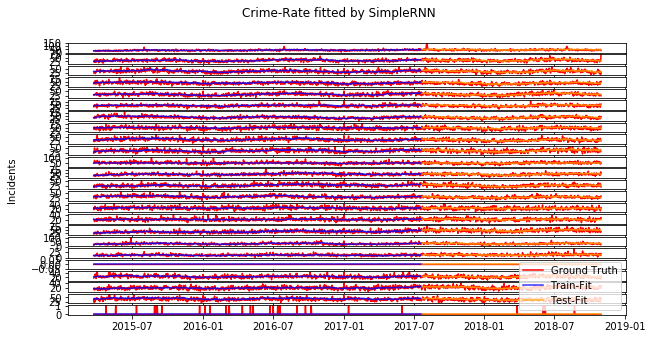

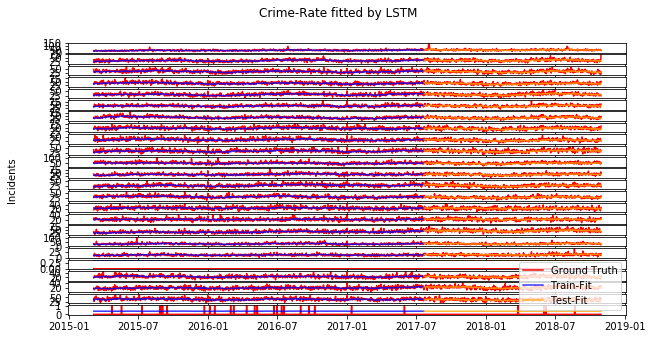

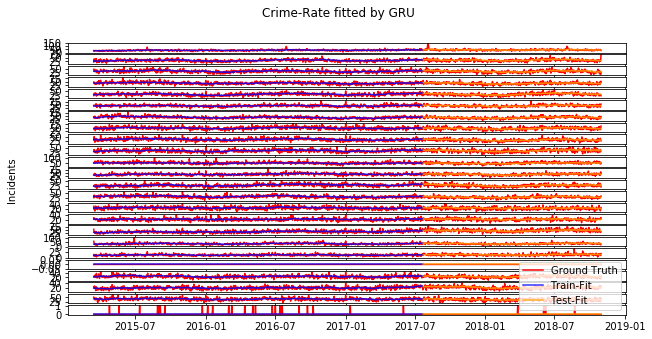

In [92]:
def typecast(params):
    """Fix types of hyperopt.Trials"""
    out = {}
    optimizers = ["adam", "sgd"]
    for key, val in params.items():
        if key == "optimizer":
            # val is 0 or 1, transform into string
            out[key] = optimizers[val]
        else:
            try:
                # take a float, turn it into an int
                out[key] = int(val)
            except TypeError:
                out[key] = val
    return out

name2cell = {"RNN": SimpleRNN,
             "LSTM": LSTM,
             "GRU": GRU}

series_col = []
cell_col = []
loss_L1_col = []
loss_L2_col = []

for name, cell in tqdm(name2cell.items()):
    bestparams = typecast({"cell": cell,
                          **best[cell.__name__]})
        
    model = Recurrent(data, epochs=3, train_size=train_size,
                      **bestparams, verbose=False)
    model.train()
        
    path = os.path.join("analysis", "models", "best_" + name + ".png")
    y_pred = model.forecast(model.X_test)
    
    loss_L1 = mean_absolute_error(y_true=model.y_test,
                                  y_pred=y_pred)
    loss_L2 = mean_squared_error(y_true=model.y_test,
                                 y_pred=y_pred)

    cell_col.append(name)
    loss_L2_col.append(loss_L2)
    loss_L1_col.append(loss_L1);

Additionally, we compare the models to a naive model, that simply outputs the previous days' number of reported crimes.

In [93]:
# Naive Model: prediction equal to previous day.
district["Baseline"] = district.groupby("District").shift(1)
district.dropna(axis=0, inplace=True)

# Calculate baseline model performance.
cell_col.insert(0, "Baseline")
baseline_L1 = mean_absolute_error(y_true=district.Incidents,
                                  y_pred=district.Baseline)
loss_L1_col.insert(0, baseline_L1)
baseline_L2 = mean_squared_error(y_true=district.Incidents,
                                 y_pred=district.Baseline)
loss_L2_col.insert(0, baseline_L2)

And we save everything to a `pd.DataFrame`.

In [94]:
validation = pd.DataFrame({"Model": cell_col,
                           "Validation L1 Loss": loss_L1_col,
                           "Validation L2 Loss": loss_L2_col})
validation.to_csv(os.path.join("analysis", "models", "loss.csv"), index=False)